### Part II: Performance Evaluation of Classical Bandit Algorithms

#### Implementation for the Bandit Algorithms:

In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

class Bandit_Algorithm:
    def __init__(self, N, T, theta_oracled):
        self.N = N
        self.T = T
        self.theta_oracled = theta_oracled
        self.bandit_num = len(theta_oracled)
        self.best_arm = np.argmax(theta_oracled)

        self.regret = None
        self.reward = None
        self.optimal_choice = None
        self.name = None
        self.label_name = None
        self.param_list = None
        self.algorithm = None


    def __call__(self):
        print(f"Running {self.name} Algorithm...")
        for i, param in enumerate(self.param_list):
            for _ in tqdm.tqdm(range(self.T)):
                reward, optimal_choice = self.algorithm(param)
                self.reward[i, :] += reward / self.T
                self.optimal_choice[i, :] += optimal_choice / np.float64(self.T)
            self.regret[i] = (np.arange(0, self.N) + 1) * self.theta_oracled[self.best_arm] - np.cumsum(self.reward[i, :])


    def report(self):
        print(f"Reporting {self.name} Algorithm...")
        max_len = max([len(str(param)) for param in self.param_list])
        for i, param in enumerate(self.param_list):
            print(f'param: {str(param):<{max_len + 5}}  Average Regret: {self.regret[i, -1]:<10.2f}  Average Optimal Choice: {self.optimal_choice[i, -1] * np.float64(100.0):.4f}%')

        for i, param in enumerate(self.param_list):
            plt.plot(self.regret[i, :], label=f"{self.label_name}={param}")
        plt.xlabel("Turns")
        plt.ylabel("Average Regret")
        plt.title(f"{self.name} Algorithm Regret")
        plt.legend()
        plt.show()

        for i, param in enumerate(self.param_list):
            plt.plot(self.optimal_choice[i, :], label=f"{self.label_name}={param}")
        plt.xlabel("Turns")
        plt.ylabel("Average Optimal Choice (%)")
        plt.title(f"{self.name} Algorithm Optimal Choice (%)")
        plt.legend()
        plt.show()


class Epsilon_Greedy_Algorithm(Bandit_Algorithm):
    def __init__(self, N, T, theta_oracled, epsilon_list):
        super().__init__(N, T, theta_oracled)
        self.param_list = epsilon_list
        self.optimal_choice = np.zeros((len(epsilon_list), N), dtype=np.float64)
        self.reward = np.zeros((len(epsilon_list), N))
        self.regret = np.zeros((len(epsilon_list), N))
        self.name='Epsilon-Greedy'
        self.label_name='$\epsilon$'
        self.algorithm = self.epsilon_greedy


    def epsilon_greedy(self, epsilon):
        prob = np.random.uniform(0, 1, self.N)

        count = np.zeros(self.bandit_num)
        theta = np.zeros(self.bandit_num)
        reward = np.zeros(self.N)
        optimal_choice = np.zeros(self.N, dtype=np.float64)

        for t in range(self.N):
            selected_arm = 0
            if prob[t] < epsilon: # explore: randomly choose an arm from {0, ..., self.bandit_num - 1}
                selected_arm = np.random.randint(0, self.bandit_num)
            else: # exploit
                selected_arm = np.argmax(theta)

            r_i = np.random.binomial(1, self.theta_oracled[selected_arm]) # r_i ~ Bern(theta_oracled[selected_arm])
            count[selected_arm] += 1
            theta[selected_arm] += 1 / count[selected_arm] * (r_i - theta[selected_arm])

            reward[t] = r_i
            if selected_arm == self.best_arm:
                optimal_choice[t] = np.float64(1)

        return reward, optimal_choice


class UCB_Algorithm(Bandit_Algorithm):
    def __init__(self, N, T, theta_oracled, c_list):
        super().__init__(N, T, theta_oracled)
        self.param_list = c_list
        self.optimal_choice = np.zeros((len(c_list), N), dtype=np.float64)
        self.reward = np.zeros((len(c_list), N))
        self.regret = np.zeros((len(c_list), N))
        self.name='UCB'
        self.label_name='c'
        self.algorithm = self.UCB


    def UCB(self, c):
        count = np.zeros(self.bandit_num)
        theta = np.zeros(self.bandit_num)
        reward = np.zeros(self.N)
        optimal_choice = np.zeros(self.N, dtype=np.float64)

        for t in range(self.N):
            # initialization
            if t < self.bandit_num:
                selected_arm = t
            else:
                selected_arm = np.argmax(theta + c * np.sqrt(2 * np.log(t) / count))

            r_i = np.random.binomial(1, self.theta_oracled[selected_arm]) # r_i ~ Bern(theta_oracled[selected_arm])
            count[selected_arm] += 1
            theta[selected_arm] += 1 / count[selected_arm] * (r_i - theta[selected_arm])

            reward[t] = r_i
            if selected_arm == self.best_arm:
                optimal_choice[t] = np.float64(1)

        return reward, optimal_choice


class Thompson_Sampling_Algorithm(Bandit_Algorithm):
    def __init__(self, N, T, theta_oracled, alpha_beta_list):
        super().__init__(N, T, theta_oracled)
        self.param_list = alpha_beta_list
        self.optimal_choice = np.zeros((len(alpha_beta_list), N), dtype=np.float64)
        self.reward = np.zeros((len(alpha_beta_list), N))
        self.regret = np.zeros((len(alpha_beta_list), N))
        self.name='Thompson Sampling'
        self.label_name='$\\alpha,\\beta$'
        self.algorithm = self.Thompson_Sampling


    def Thompson_Sampling(self, alpha_beta_origin):
        count = np.zeros(self.bandit_num)
        theta = np.zeros(self.bandit_num)
        reward = np.zeros(self.N)
        optimal_choice = np.zeros(self.N, dtype=np.float64)

        alpha_beta = alpha_beta_origin.copy()

        for t in range(self.N):
            for i in range(self.bandit_num):
                alpha, beta = alpha_beta[i]
                theta[i] = np.random.beta(alpha, beta) # theta[i] ~ Beta(alpha, beta)

            selected_arm = np.argmax(theta)

            r_i = np.random.binomial(1, self.theta_oracled[selected_arm]) # r_i ~ Bern(theta_oracled[selected_arm])
            count[selected_arm] += 1
            theta[selected_arm] += 1 / count[selected_arm] * (r_i - theta[selected_arm])
            alpha_beta[selected_arm] = (alpha_beta[selected_arm][0] + r_i, alpha_beta[selected_arm][1] + 1 - r_i)

            reward[t] = r_i
            if selected_arm == self.best_arm:
                optimal_choice[t] = np.float64(1)

        return reward, optimal_choice


class Gradient_Bandit_Algorithm(Bandit_Algorithm):
    def __init__(self, N, T, theta_oracled, b_beta_list):
        super().__init__(N, T, theta_oracled)
        self.param_list = b_beta_list
        self.optimal_choice = np.zeros((len(b_beta_list), N), dtype=np.float64)
        self.reward = np.zeros((len(b_beta_list), N))
        self.regret = np.zeros((len(b_beta_list), N))
        self.name='Gradient Bandit'
        self.label_name='$b,\\beta$'
        self.algorithm = self.gradient


    def softmax(self, H, beta, t):
        if type(beta) == str:
            beta_0, beta_T = 1, 10
            beta = beta_0 + np.log(1 + 9 * t / self.N) / np.log(10) * (beta_T - beta_0)
        exp_H = np.exp(beta * H)
        return exp_H / np.sum(exp_H)


    def get_action(self, policy, random_num):
        selected_arm = 0
        # this could be optimized by using binary search, but bandit_num = 3, it is not worth it
        for i in range(self.bandit_num):
            if random_num <= policy[i]:
                selected_arm = i
                break
            random_num -= policy[i]
        return selected_arm


    def gradient(self, b_beta):
        reward = np.zeros(self.N)
        optimal_choice = np.zeros(self.N, dtype=np.float64)

        random_num = np.random.uniform(0, 1, self.N)
        b, beta = b_beta

        H = np.zeros(self.bandit_num)
        alpha = 0.1
        average_reward = 0

        for t in range(self.N):
            policy = self.softmax(H, beta, t)
            selected_arm = self.get_action(policy, random_num[t])

            r_i = np.random.binomial(1, self.theta_oracled[selected_arm]) # r_i ~ Bern(theta_oracled[selected_arm])
            reward[t] = r_i
            if selected_arm == self.best_arm:
                optimal_choice[t] = np.float64(1)

            # update H
            average_reward = t / (t + 1) * average_reward + 1 / (t + 1) * r_i # incremental implementation
            if b != -1: # baseline
                average_reward = b
            H += alpha * (r_i - average_reward) * (np.eye(self.bandit_num)[selected_arm] - policy)

        return reward, optimal_choice

#### Problem (2)
Implement classical bandit algorithms with following settings:
- $N=5000$
- $\epsilon$-greedy with $\epsilon=0.1,0.5,0.9$.
- UCB with $c=1,5,10$.
- Thompson Sampling with $\left\{\left(\alpha_1, \beta_1\right)=(1,1),\left(\alpha_2, \beta_2\right)=(1,1),\left(\alpha_3, \beta_3\right)=(1,1)\right\}$ and $\left\{\left(\alpha_1, \beta_1\right)=(601,401),\left(\alpha_2, \beta_2\right)=(401,601),\left(\alpha_3, \beta_3\right)=(2,3)\right\}$
- Gradient bandit with baseline $b=0,0.8,5,20$.
- Parameterized gradient bandit with constant parameter $\beta=0.2,1,2,5$
- Parameterized gradient bandit with time-varying parameters (you need to design a time-varying rule)

In [2]:
theta_oracled = [0.9, 0.8, 0.7]
epsilon_list = [0.1, 0.5, 0.9]
c_list = [1, 5, 10]
alpha_beta_list = [[(1, 1), (1, 1), (1, 1)], [(601, 401), (401, 601), (2, 3)]]
b_beta_list = [(0, 1), (0.8, 1), (5, 1), (20, 1), (-1, 0.2), (-1, 1), (-1, 2), (-1, 5), (-1, 'vary')]
N, T = 5000, 1000

epsilon_greedy = Epsilon_Greedy_Algorithm(N=N, T=T, theta_oracled=theta_oracled, epsilon_list=epsilon_list)
ucb = UCB_Algorithm(N=N, T=T, theta_oracled=theta_oracled, c_list=c_list)
thompson_sampling = Thompson_Sampling_Algorithm(N=N, T=T, theta_oracled=theta_oracled, alpha_beta_list=alpha_beta_list)
gradient_bandit = Gradient_Bandit_Algorithm(N=N, T=T, theta_oracled=theta_oracled, b_beta_list=b_beta_list)

#### Problem (3)
Each experiment lasts for $N=5000$ turns, and we rum each experiment 1000 times. Results are averaged over these 1000 independent rums.

In [3]:
epsilon_greedy()
ucb()
thompson_sampling()
gradient_bandit()

Running Epsilon-Greedy Algorithm...


100%|██████████| 1000/1000 [00:18<00:00, 54.62it/s]


Running UCB Algorithm...


100%|██████████| 1000/1000 [00:36<00:00, 27.57it/s]


Running Thompson Sampling Algorithm...


100%|██████████| 1000/1000 [00:29<00:00, 33.40it/s]


Running Gradient Bandit Algorithm...


100%|██████████| 1000/1000 [01:04<00:00, 15.61it/s]


#### Problem (4)
Please report three performance metrics
- The total regret accumulated over the experiment.
- The regret as a function of time.
- The percentage of plays in which the optimal arm is pulled.

Reporting Epsilon-Greedy Algorithm...
param: 0.1       Average Regret: 53.32       Average Optimal Choice: 93.1000%
param: 0.5       Average Regret: 252.07      Average Optimal Choice: 67.3000%
param: 0.9       Average Regret: 450.35      Average Optimal Choice: 40.5000%


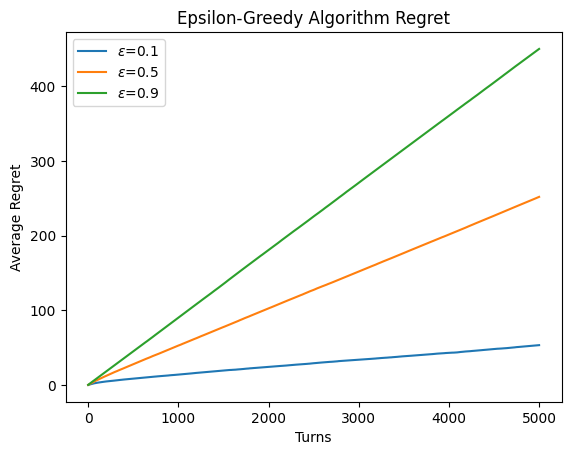

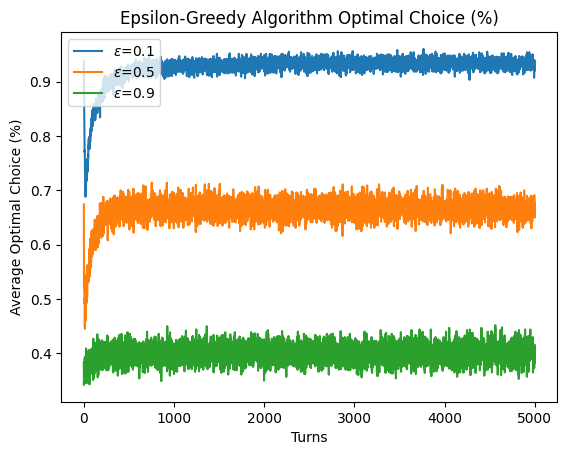

Reporting UCB Algorithm...
param: 1        Average Regret: 113.60      Average Optimal Choice: 92.6000%
param: 5        Average Regret: 372.88      Average Optimal Choice: 52.2000%
param: 10       Average Regret: 433.60      Average Optimal Choice: 37.7000%


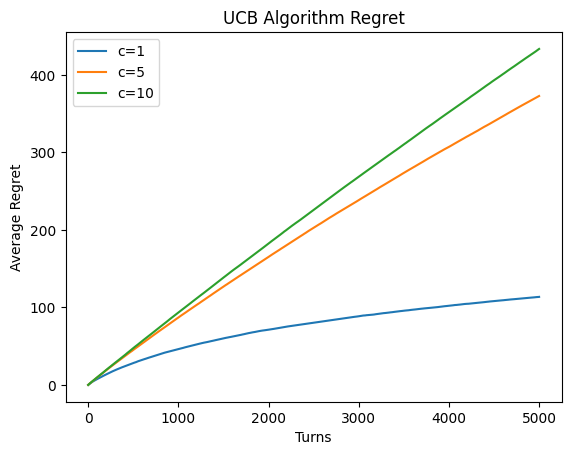

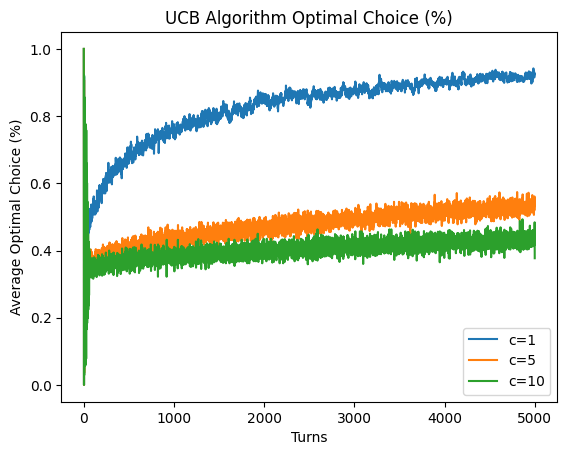

Reporting Thompson Sampling Algorithm...
param: [(1, 1), (1, 1), (1, 1)]               Average Regret: 14.64       Average Optimal Choice: 99.7000%
param: [(601, 401), (401, 601), (2, 3)]       Average Regret: 715.76      Average Optimal Choice: 30.0000%


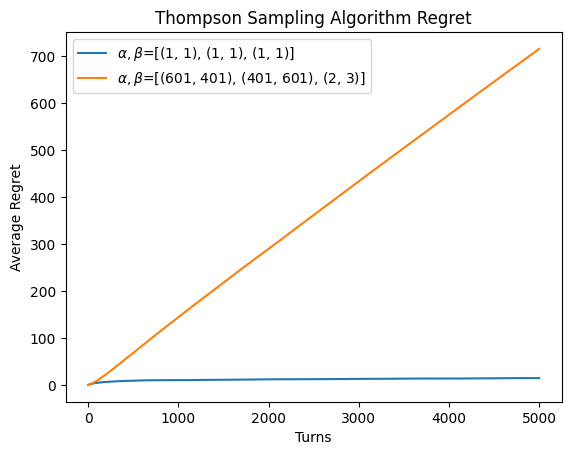

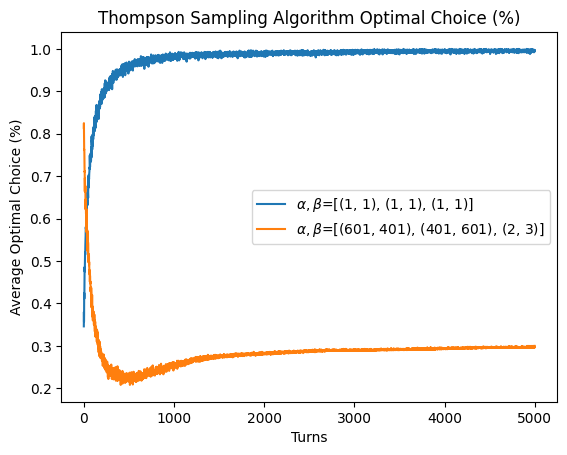

Reporting Gradient Bandit Algorithm...
param: (0, 1)             Average Regret: 72.74       Average Optimal Choice: 96.3000%
param: (0.8, 1)           Average Regret: 50.51       Average Optimal Choice: 98.8000%
param: (5, 1)             Average Regret: 383.75      Average Optimal Choice: 47.4000%
param: (20, 1)            Average Regret: 493.35      Average Optimal Choice: 35.0000%
param: (-1, 0.2)          Average Regret: 175.08      Average Optimal Choice: 92.0000%
param: (-1, 1)            Average Regret: 49.91       Average Optimal Choice: 99.4000%
param: (-1, 2)            Average Regret: 29.68       Average Optimal Choice: 99.0000%
param: (-1, 5)            Average Regret: 15.47       Average Optimal Choice: 99.7000%
param: (-1, 'vary')       Average Regret: 17.88       Average Optimal Choice: 100.0000%


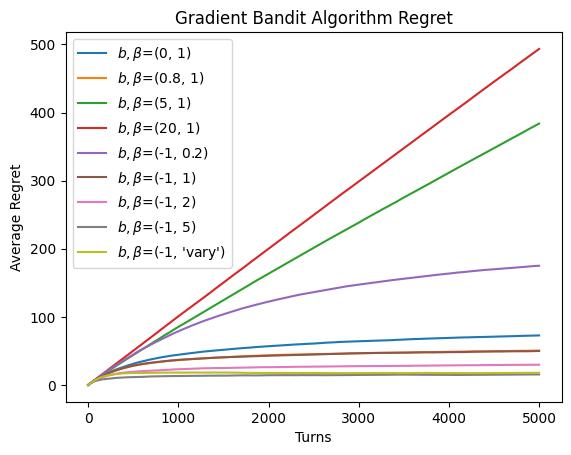

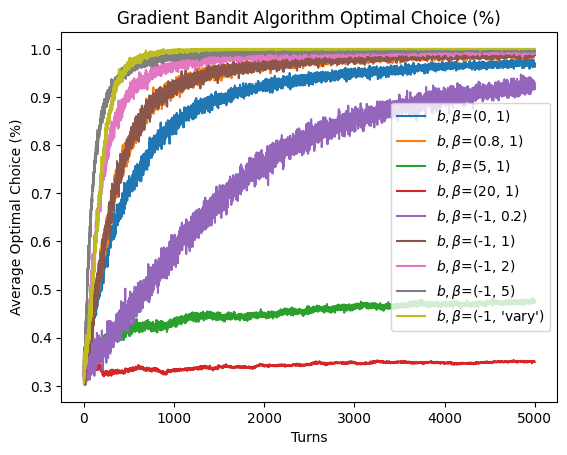

In [4]:
epsilon_greedy.report()
ucb.report()
thompson_sampling.report()
gradient_bandit.report()

#### Problem (6)
What is the role of baseline in gradient bandit algorithm? Show your answer with simulation result.

Running Gradient Bandit Algorithm...


100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s]


Reporting Gradient Bandit Algorithm...
param: (-1, 1)       Average Regret: 51.85       Average Optimal Choice: 99.0000%
param: (0, 1)        Average Regret: 72.37       Average Optimal Choice: 97.7000%
param: (1, 1)        Average Regret: 50.56       Average Optimal Choice: 98.5000%
param: (-1, 2)       Average Regret: 29.28       Average Optimal Choice: 99.9000%
param: (0, 2)        Average Regret: 84.29       Average Optimal Choice: 91.8000%
param: (1, 2)        Average Regret: 30.19       Average Optimal Choice: 99.3000%
param: (-1, 5)       Average Regret: 15.68       Average Optimal Choice: 99.9000%
param: (0, 5)        Average Regret: 139.70      Average Optimal Choice: 80.4000%
param: (1, 5)        Average Regret: 16.23       Average Optimal Choice: 99.7000%


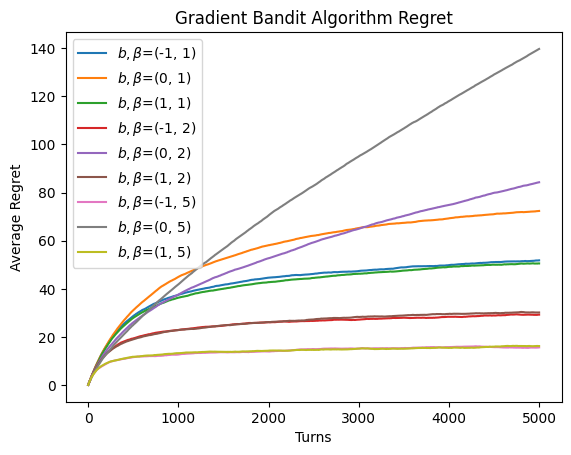

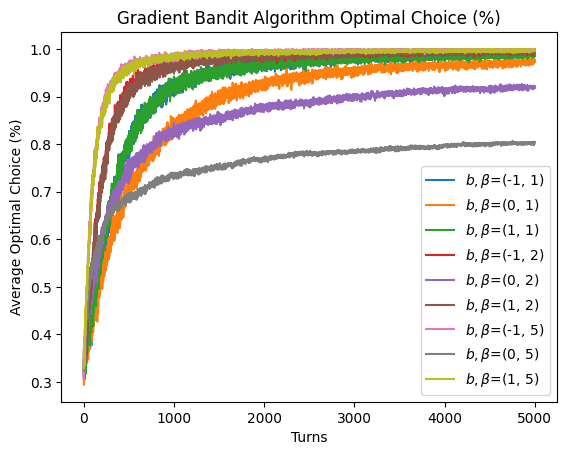

In [5]:
b_beta_list = [(-1, 1), (0, 1), (1, 1), (-1, 2), (0, 2), (1, 2), (-1, 5), (0, 5), (1, 5)]
N, T = 5000, 1000
gradient_bandit_baseline = Gradient_Bandit_Algorithm(N=N, T=T, theta_oracled=theta_oracled, b_beta_list=b_beta_list)
gradient_bandit_baseline()
gradient_bandit_baseline.report()